In the previous file, we learned that creating indexes can speed up commonly executed queries. We also learned that a multi-column index can be used when we filter on multiple columns at once.

In this file, we will introduce another concept, **vacuuming**, to improve table querying speeds. This new concept will rely on a counter intuitive understanding of Postgres destructive queries. Recall that destructive queries alter or destroy table data (for example, `UPDATE` and `DELETE`).

Let's begin with a simple example to get started. Assume that we have loaded data into one of the HUD tables, `homeless_by_coc`, and we accidently deleted all the data with a `DELETE` command. After a brief moment of panic, we realize that everything will be fine once we reload the data by copying it from the file,`homeless_by_coc.csv`.

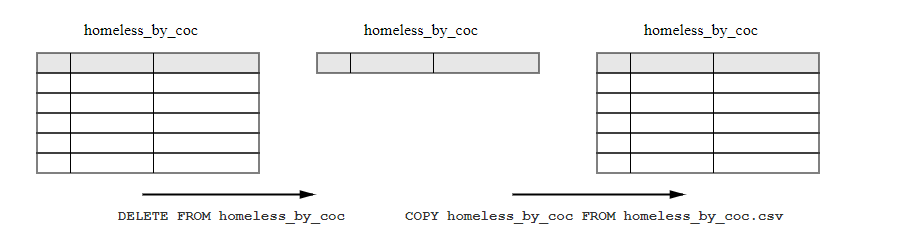


After a delete and load, nothing has changed and we validate the data is the same. However, after running a couple queries, we notice things seem a bit slower than before. We run a benchmark query with `EXPLAIN ANALYZE`, and we notice that query speeds have gone up since we deleted and reloaded the data.

Shouldn't the speed be the same? Why would query speeds be affected by a few deletions? In this file, we will learn the process by which Postgres runs destructive commands, the reason why it can have a non-trivial effect on querying speeds, and the internal tools to reclaim the lost speed.

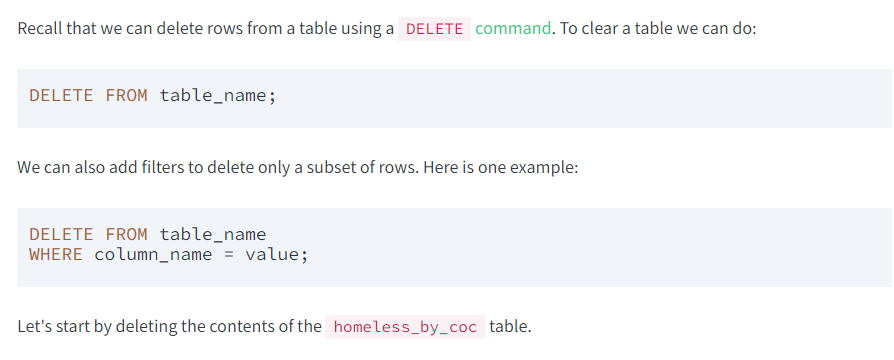

**Task**

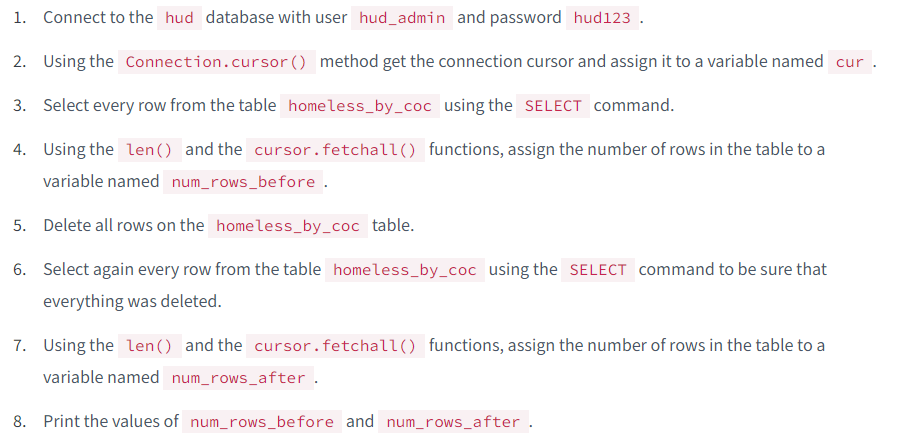

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname="hud", user="hud_admin", password="hud123")
cur = conn.cursor()`

`cur.execute("SELECT * FROM homeless_by_coc;")
num_rows_before = len(cur.fetchall())`

`cur.execute("DELETE FROM homeless_by_coc;")
cur.execute("SELECT * FROM homeless_by_coc;")
num_rows_after = len(cur.fetchall())`

`print(num_rows_before)
print(num_rows_after)`

When we run a `DELETE` query, we might assume that the data has been totally removed from the system but this is not the case. Instead of removing the rows from the table, Postgres will mark the rows as **dead**, which means they will **eventually** be removed. It is similar to deleting a file from our system by moving it into the recycling (or trash) folder, then having the operating system remove it entirely.

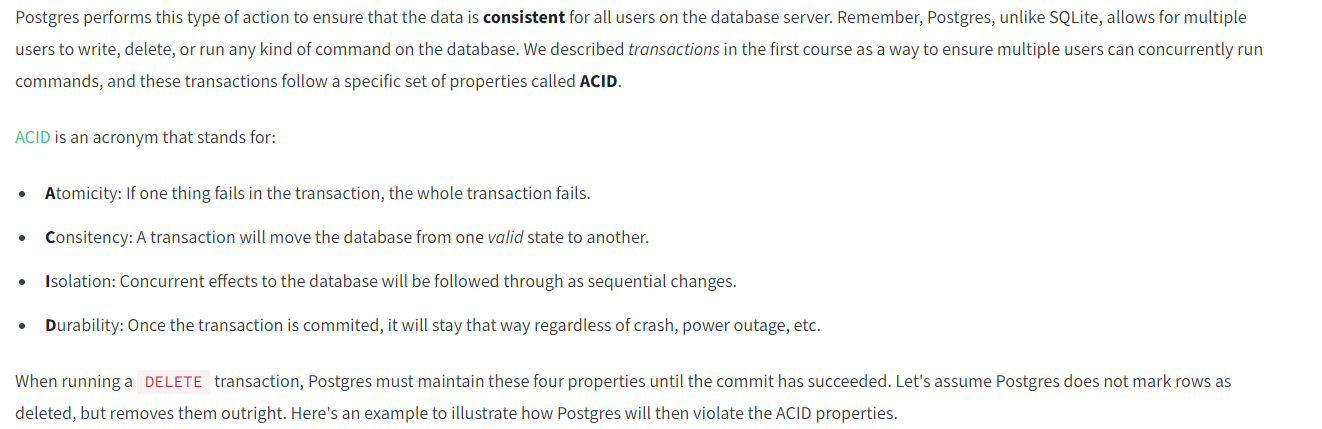

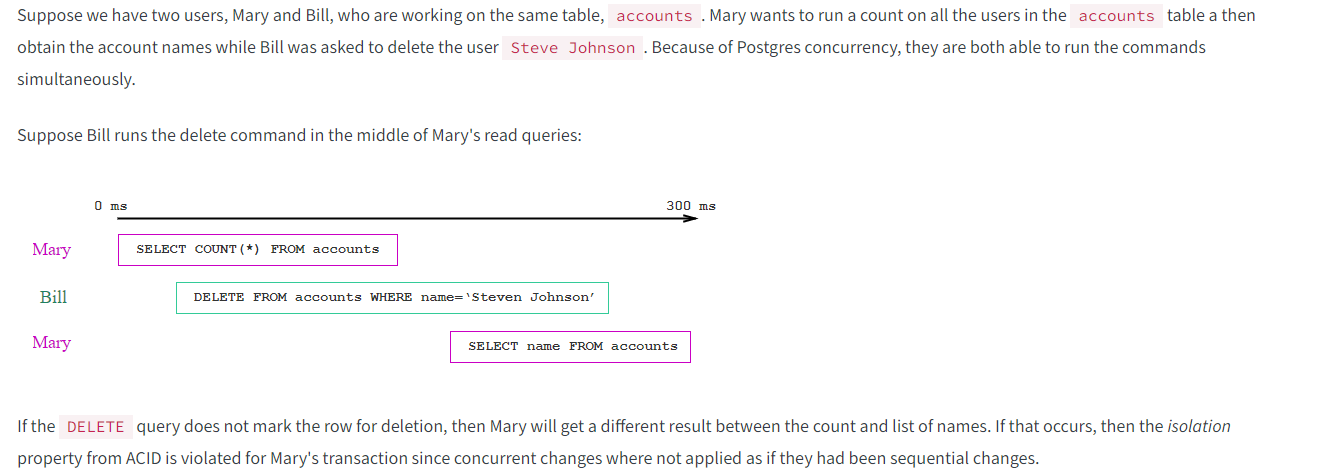

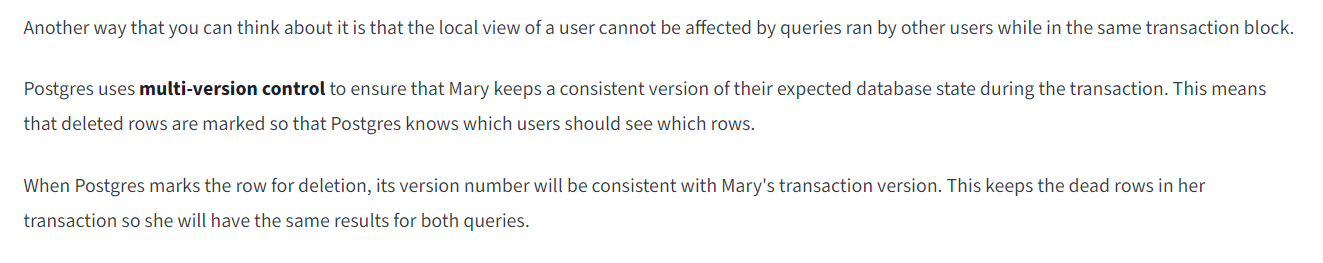

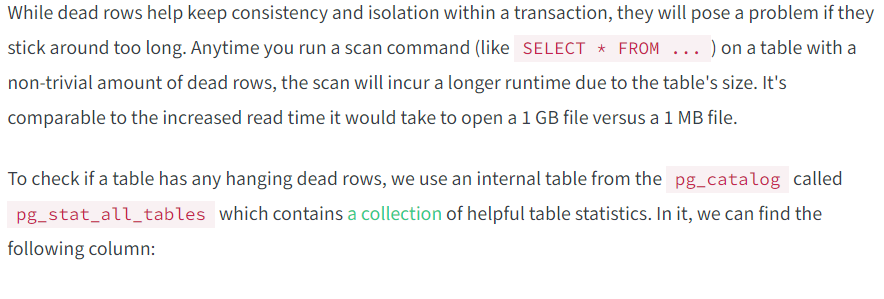

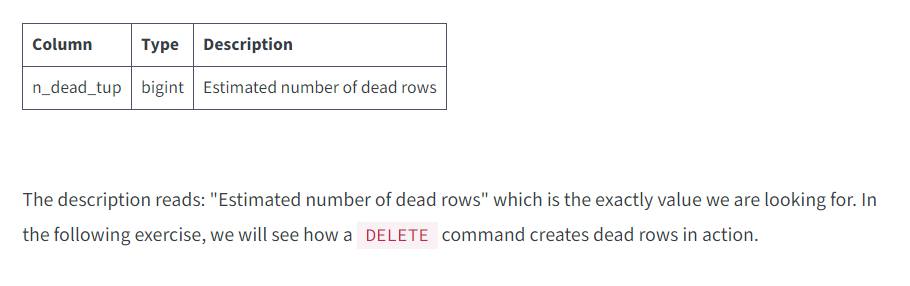

**Task**

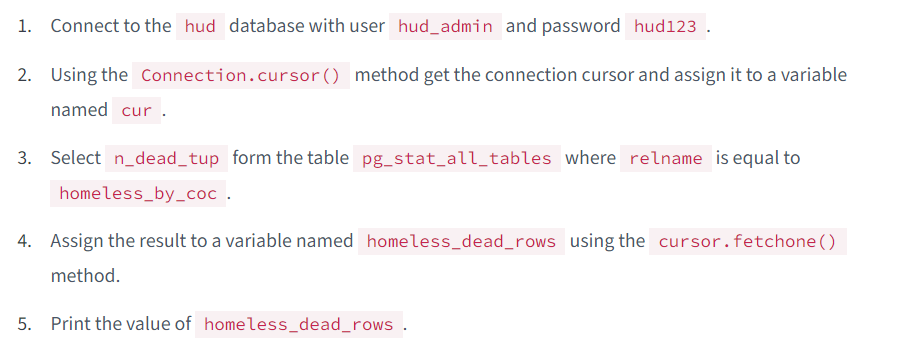

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname="hud", user="hud_admin", password="hud123")
cur = conn.cursor()`

`cur.execute("""
    SELECT n_dead_tup
    FROM pg_catalog.pg_stat_all_tables 
    WHERE relname='homeless_by_coc';
""")`

`homeless_dead_rows = cur.fetchone()[0]
print(homeless_dead_rows)`

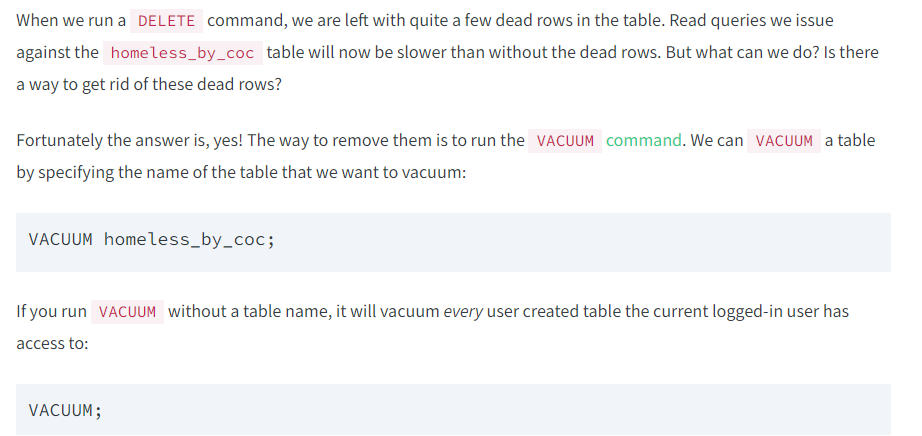

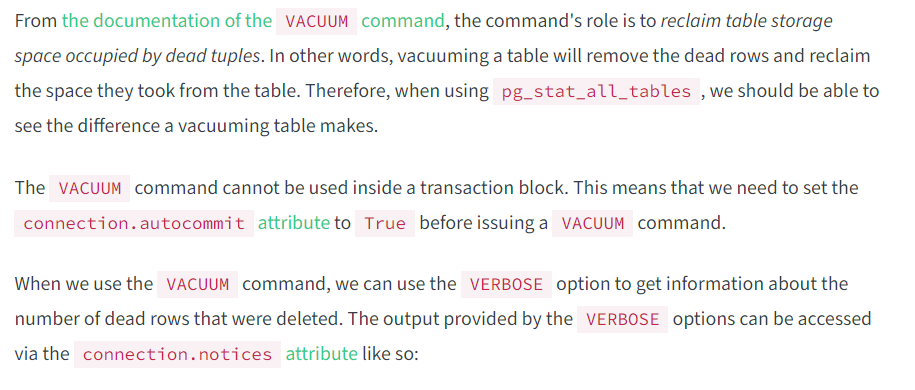

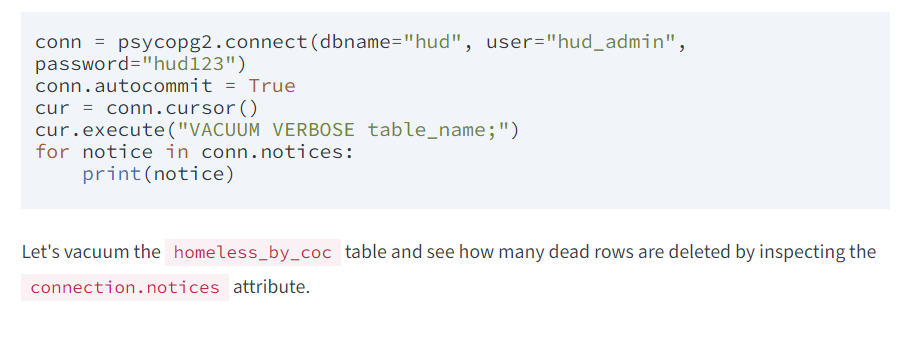

**Task**

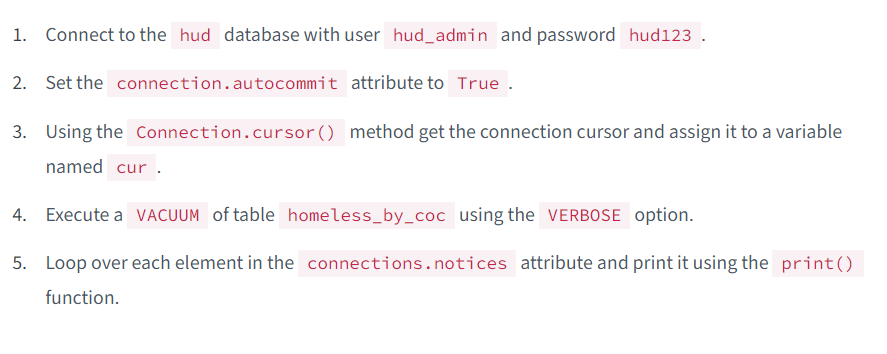

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname="hud", user="hud_admin", password="hud123")
cur = conn.cursor()`

`conn.autocommit = True
cur.execute("VACUUM VERBOSE homeless_by_coc;")`

`for notice in conn.notices:
    print(notice)`

In the above exercise, we executed the `VACUUM VERBOSE` command to vacuum the table and obtain information about the vacuum operation. By inspecting the `connection.notices` attribute, we obtained the following information:

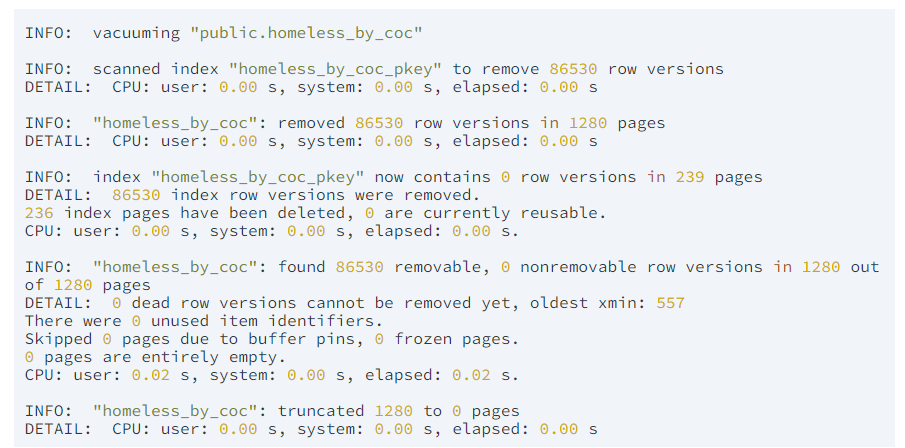

We can see that 86,530 rows were removed from the `homeless_by_coc` table. Also, the corresponding entries were removed from the index `homeless_by_coc_pkey` which is the index used on the primary key of the `homeless_by_coc` table. These correspond to the rows that we deleted earlier.`

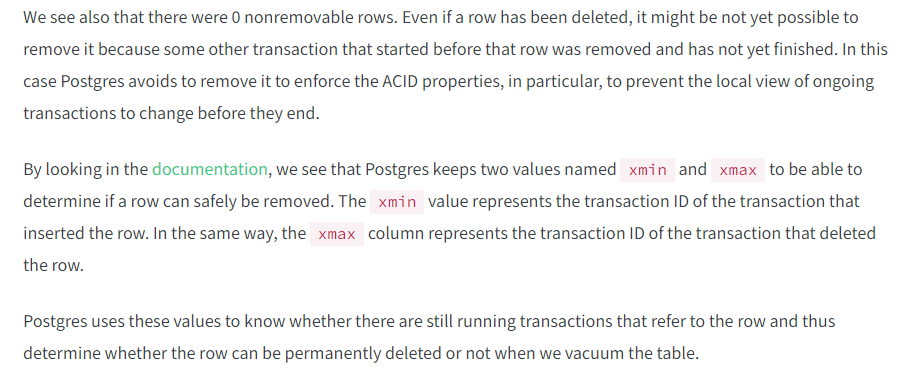

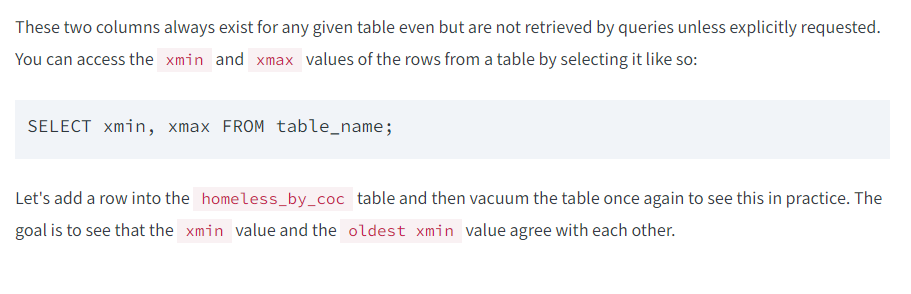

**Task**

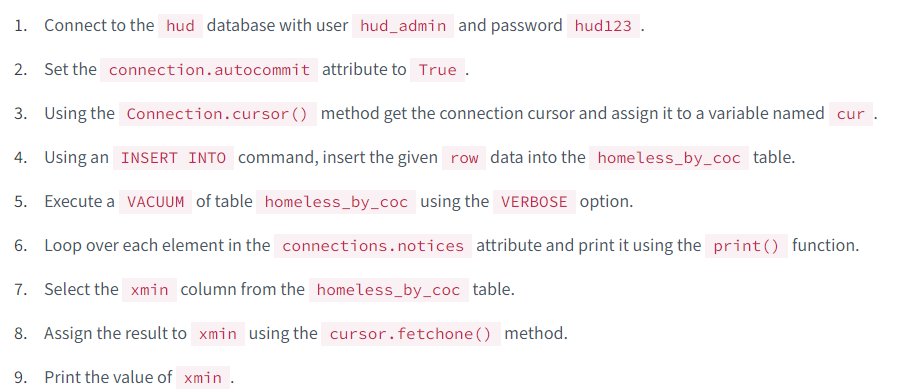

**Answer**

`import psycopg2
row = (1, '2007-01-01', 'AK', 'AK-500', 'Anchorage CoC', 'Chronically Homeless Individuals', 224)
conn = psycopg2.connect(dbname='hud', user='hud_admin', password='hud123')
conn.autocommit = True
cur = conn.cursor()`

`cur.execute("INSERT INTO homeless_by_coc VALUES (%s, %s, %s, %s, %s, %s, %s);", row)
cur.execute("VACUUM VERBOSE homeless_by_coc;")`

`for line in conn.notices:
    print(line)`
    
`cur.execute("SELECT xmin FROM homeless_by_coc;")
xmin = cur.fetchone()
print(xmin)`

Above, we added a new row and then tried to vacuum the table. We obtain, in part, the following information:

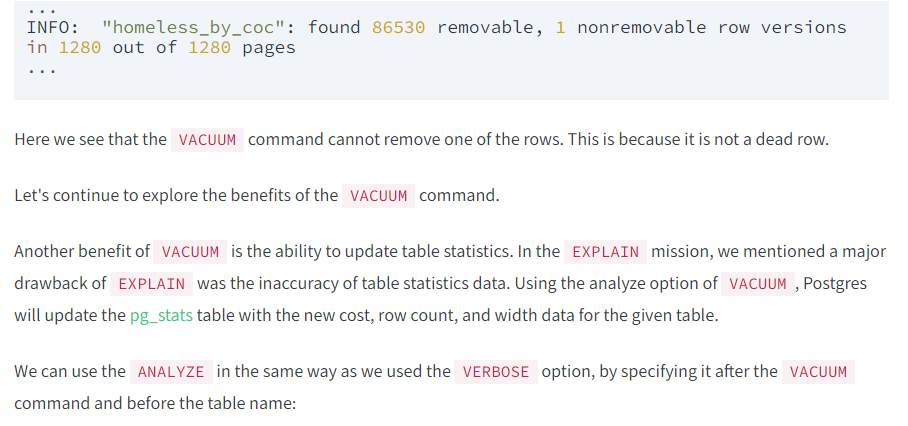

`VACUUM ANALYZE table_name;`

**Task**

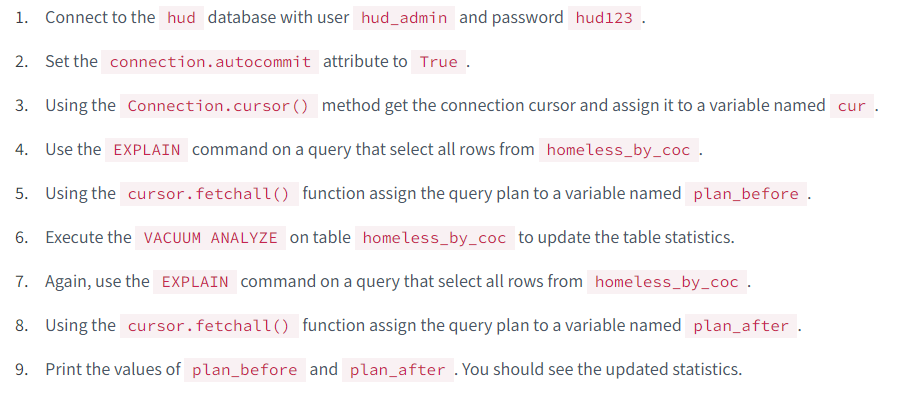

**Answer**

`import json
conn = psycopg2.connect(dbname="hud", user="hud_admin", password="hud123")
conn.autocommit = True
cur = conn.cursor()`

`cur.execute("EXPLAIN SELECT * FROM homeless_by_coc;")
plan_before = cur.fetchall()`

`cur.execute("VACUUM ANALYZE homeless_by_coc;")`

`cur.execute("EXPLAIN SELECT * FROM homeless_by_coc;")
plan_after = cur.fetchall()`

`print(plan_before)
print(plan_after)`

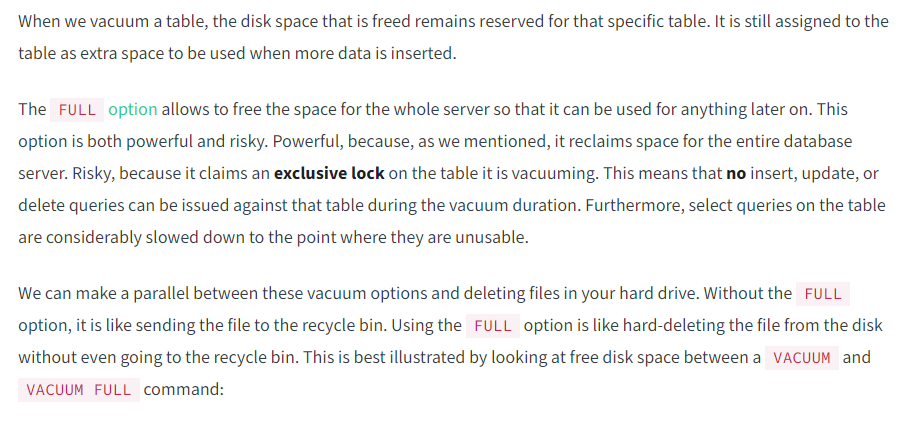

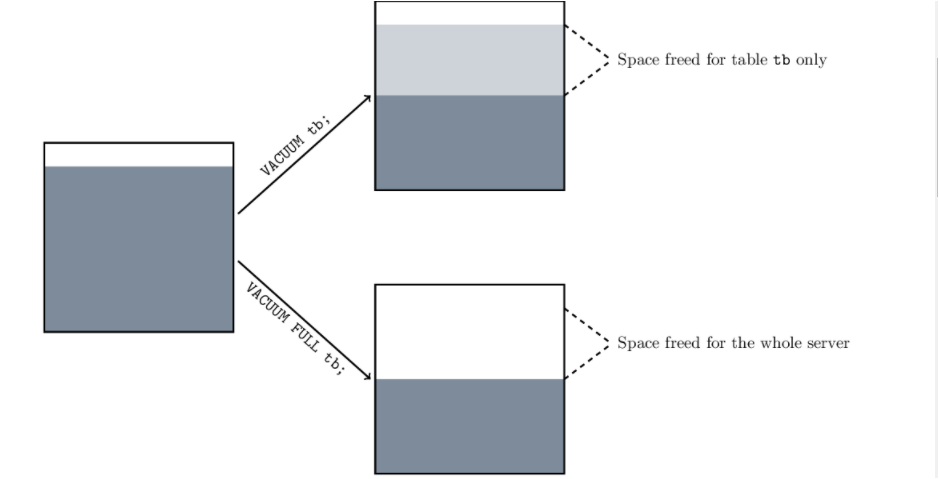

It is not recommended to run a `VACUUM FULL` periodically because of the exclusive lock that we mentioned above. The only time we should run the option is if our table consists of a high ratio of dead rows to live rows.

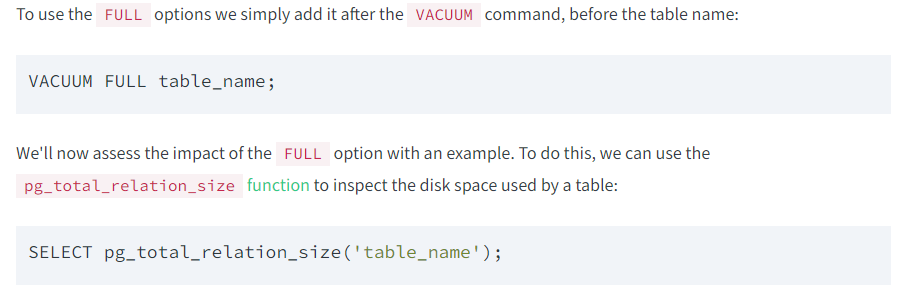

If we want to have more readable sizes we can pass the result to the `pg_size_pretty` function like so:

`SELECT pg_size_pretty(pg_total_relation_size('table_name')));`

Let's see the impact on disk space of the `VACUUM FULL` command.

**Task**

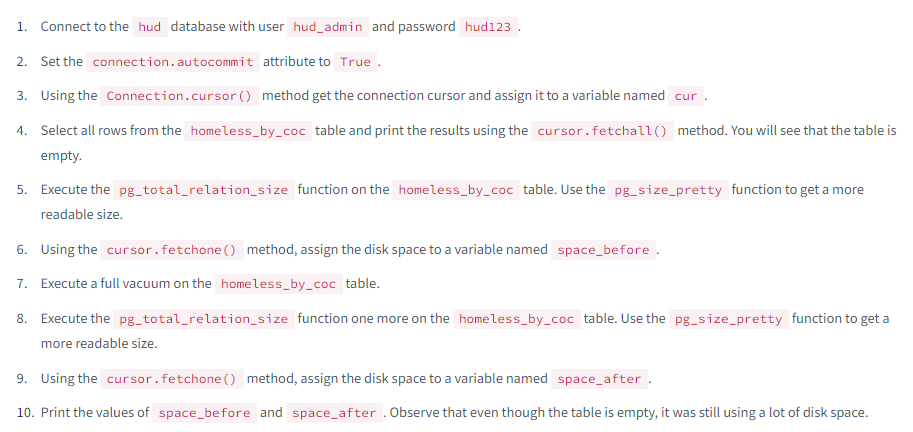

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname="hud", user="hud_admin", password="hud123")
conn.autocommit = True
cur = conn.cursor()`

`cur.execute("SELECT * FROM homeless_by_coc;")
print(cur.fetchall())`

`cur.execute("SELECT pg_size_pretty(pg_total_relation_size('homeless_by_coc'));")
space_before = cur.fetchone()`

`cur.execute("VACUUM FULL homeless_by_coc;")`

`cur.execute("SELECT pg_size_pretty(pg_total_relation_size('homeless_by_coc'));")
space_after = cur.fetchone()`

`print(space_before)
print(space_after)`

Postgres provides an optional, but highly recommended, feature to automatically vacuum our Postgres tables for us. This feature is called **autovacuum** and it runs periodically on our tables to ensure that dead rows are removed, and our statistics are up to date.

We can check whether autovacuum is enables by checking` autovacuum` setting in the [`pg_settings` table](https://www.postgresql.org/docs/current/view-pg-settings.html):

`SELECT setting FROM pg_settings 
WHERE name = 'autovacuum';`

In the latest versions of Postgres, autovacuum is on by default, and requires no additional setup. In the majority of Postgres databases we will work with, our tables will be periodically vacuumed without having to explicitly call the `VACUUM` command. Because tables are automatically vacuumed, the question becomes: when do we explicitly vacuum tables?

The kind of questions we should ask ourself to answer this are:

1. Are we running our normal analysis tasks without major table deletes and without adding a lot of new rows? Then, leave vacuuming to the autovacuum.

2. Have we recently deleted a significant amount of data in our tables, and we want to follow it up with complex analysis commands? Then, run a `VACUUM` or `VACUUM ANALYZE` to ensure optimized query commands.

3. Are our tables growing out of control, and is there little free space left on the database server? Then, disable all queries and run a `VACUUM FULL` to reclaim a significant amount of space.

These questions should serve as a guideline when choosing whether to vacuum or not. We have shown multiple ways to debug our tables using `EXPLAIN`, `n_dead_tup`, and other statistics to measure table performance. Use those stats and our discretion when deciding when to run the `VACUUM` command.

To see when was the last time a table named `table_name` was vacuumed or autovacuumed we can run the following query:

`SELECT last_vacuum, last_autovacuum FROM pg_stat_user_tables
WHERE relname = 'table_name';`

Note than when we vacuum, statistics are not immediately updated. By default these updates happen every 500 milliseconds. Therefore, if we just vacuumed a table and immediately after we execute this query, we will probably not yet see the updated time stamps.

In order to experiment, we can use the [`time.sleep()` function](https://docs.python.org/3.8/library/time.html#time.sleep) to make our program wait a little bit between the execution of the `VACUUM` and looking up the last vacuum times.

**Task**

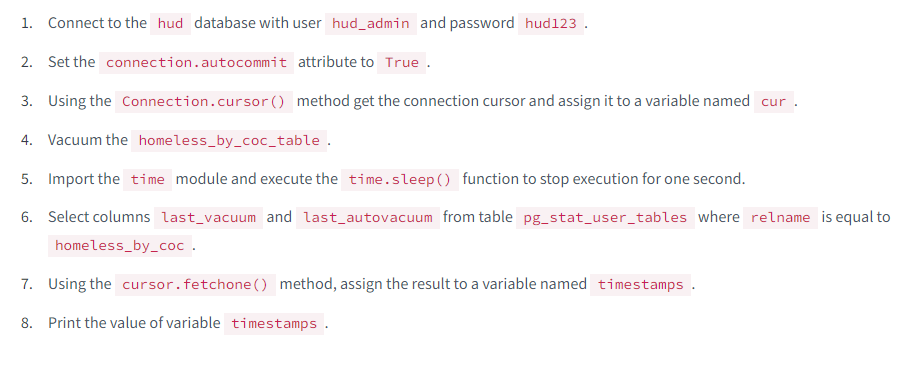

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname="hud", user="hud_admin", password="hud123")
conn.autocommit = True
cur = conn.cursor()`

`cur.execute("VACUUM homeless_by_coc;")`

`import time
time.sleep(1)`

`cur.execute("""
    SELECT last_vacuum, last_autovacuum FROM pg_stat_user_tables
    WHERE relname = 'homeless_by_coc';
""")`

`timestamps = cur.fetchone()
print(timestamps)`

In this file, we have learned:
    
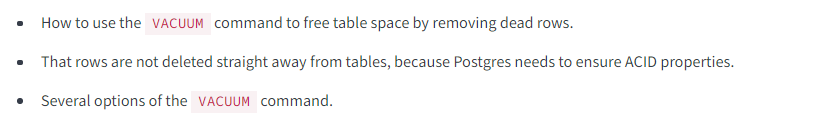